In [1]:
%reload_ext dotenv

%dotenv ../../env/.env


In [2]:
import snowflake.connector
import os

conn = snowflake.connector.connect(
    user=os.environ['SNOWFLAKE_USER'],
    role=os.environ['SNOWFLAKE_ROLE'],
    password=os.environ['SNOWFLAKE_PASSWORD'],
    account=os.environ['SNOWFLAKE_ACCOUNT'],
    warehouse=os.environ['SNOWFLAKE_WAREHOUSE'],
    database=os.environ['SNOWFLAKE_DATABASE'],
    schema=os.environ['SNOWFLAKE_SCHEMA'],
    client_session_keep_alive=True
)

conn.schema

'ACTIVITY_SCHEMA_SANDBOX'

In [3]:
# Create a cursor object.
import pandas as pd
def run_sql(sql: str, ctx=conn):
    return conn.cursor().execute(sql)

import functools
import time

@functools.cache
def sql_to_df(sql_query, pre_hook=[], ctx=conn):
    print(f"RUNNING pre-hook: {pre_hook}")
    for s in pre_hook:
        run_sql(s,conn)
        # print(f"RUNNING SQL: {sql_query}")

    # todo: move to latest method of pandas dataframe fetching
    # may need to upgrade python: https://github.com/snowflakedb/snowflake-connector-python/issues/986#issuecomment-1115354587
    
    trimmed_lowered = sql_query.strip().lower()
    if trimmed_lowered.startswith('select') or trimmed_lowered.startswith('with'):
        print(f"using arrow to fetch results...")
        cur = ctx.cursor()
        cur.execute(sql_query)
        data = cur.fetch_pandas_all() 
        cur.close()
    else:
        data = pd.read_sql(
            sql_query,
            ctx,
        )
    
    data.columns = data.columns.str.lower()
    return data

In [4]:
sql = """
select
 query_sanitized_signature,
 -- date_trunc(hour, execution_start_time) as start_hour,
 count_if(data_scanned_from_cache_gb > 0) num_cache_hits,
 count(*) as cnt,
 100*avg(case when data_scanned_from_cache_gb > 0 then percentage_scanned_from_cache else null end) as avg_pct_scanned_from_cache,
 avg(case when data_scanned_from_cache_gb > 0 then query_cost else null end) as avg_query_cost_cache_hit,
 avg(case when data_scanned_from_cache_gb = 0 then query_cost else null end) as avg_query_cost_cache_miss,
 avg(case when data_scanned_from_cache_gb > 0 then execution_time_s else null end) as avg_execution_time_s_cache_hit,
 avg(case when data_scanned_from_cache_gb = 0 then execution_time_s else null end) as avg_execution_time_s_cache_miss,
 median(case when data_scanned_from_cache_gb > 0 then query_cost else null end) as median_query_cost_cache_hit,
 median(case when data_scanned_from_cache_gb = 0 then query_cost else null end) as median_query_cost_cache_miss,
 avg_query_cost_cache_hit - avg_query_cost_cache_miss as avg_query_cost_diff,
 median_query_cost_cache_hit - median_query_cost_cache_miss as median_query_cost_diff,
 
 100*div0null(avg_query_cost_cache_hit - avg_query_cost_cache_miss,avg_query_cost_cache_miss) as pct_diff_avg,
 100*div0null(median_query_cost_cache_hit - median_query_cost_cache_miss,median_query_cost_cache_miss) as pct_diff_median
from query_history_enriched
where warehouse_size is not null and data_scanned_gb > 0
group by 1
having num_cache_hits > 4 and (cnt - num_cache_hits) > 1 and avg_query_cost_cache_miss > 0.5
"""
df = sql_to_df(sql)
df

RUNNING pre-hook: []
using arrow to fetch results...


,query_sanitized_signature,num_cache_hits,cnt,avg_pct_scanned_from_cache,avg_query_cost_cache_hit,avg_query_cost_cache_miss,avg_execution_time_s_cache_hit,avg_execution_time_s_cache_miss,median_query_cost_cache_hit,median_query_cost_cache_miss,avg_query_cost_diff,median_query_cost_diff,pct_diff_avg,pct_diff_median
0,8d2a510543bfc3e9772d0c131a2485c3,19,21,59.391997,1.937543,11.327141,417.305052631579,1577.966500000000,0.308110,11.327141,-9.389599,-11.019031,-82.894689,-97.279892
1,29d72a1ce445c047fdd7c97726a7d8d3,244,355,53.633906,0.700052,1.912089,52.062991803279,150.185585585586,0.041707,0.101643,-1.212037,-0.059936,-63.388112,-58.967153
2,1255204b9179981151d3fe0468dcbfdc,17,23,60.982393,0.064734,0.531732,4.047823529412,50.511333333333,0.035228,0.511563,-0.466998,-0.476335,-87.825754,-93.113587
3,7f683b126ef52e773ad7abeaac06d26b,22,24,60.586228,0.931860,1.127952,141.979772727273,148.951000000000,0.973342,1.127952,-0.196092,-0.154610,-17.384764,-13.707134
4,6e9245ccb2495f211a4767fc9fe5dd83,9,15,86.162703,0.391144,0.652707,0.739777777778,1.104333333333,0.086542,0.181398,-0.261563,-0.094856,-40.073516,-52.291522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,392d06e0f40b0d76f02ab4a00911b0d9,52,70,91.479498,0.073396,1.039391,0.689134615385,1.115555555556,0.005997,0.022061,-0.965995,-0.016064,-92.938556,-72.816980
196,ccf24ff54d2997b5daf155e1d01d1fe0,583,801,90.989899,0.152632,0.555403,3.086780445969,14.358504587156,0.014076,0.097421,-0.402771,-0.083344,-72.518712,-85.550840
197,d63b587e9c3887aaa8bbd3e465839020,62,78,30.948151,0.071596,0.693849,2.399774193548,27.906750000000,0.015973,0.123449,-0.622253,-0.107476,-89.681270,-87.060830
198,8f24ff03717198321ade59e83f738f15,13,18,31.772901,0.916892,0.910097,17.059923076923,19.763600000000,0.576378,0.927170,0.006795,-0.350792,0.746618,-37.834657


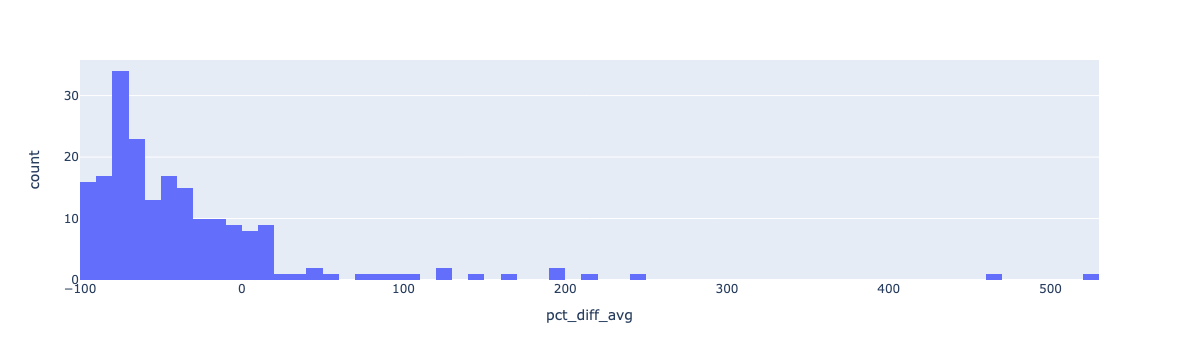

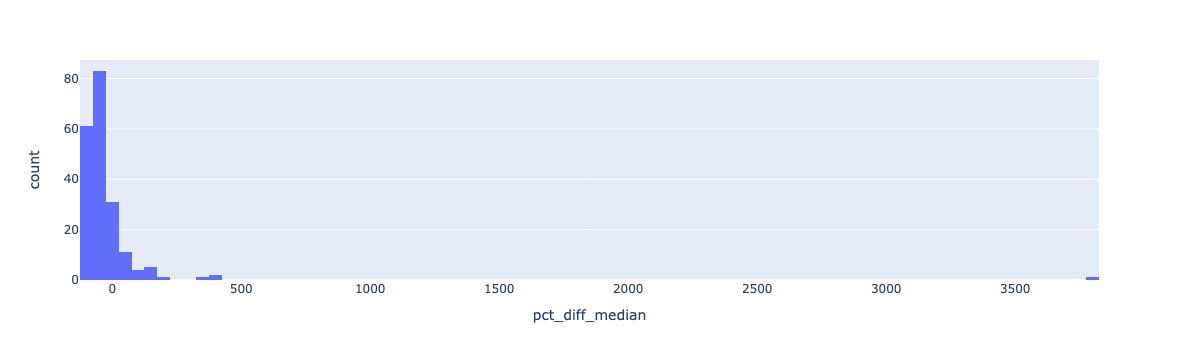

In [8]:
import plotly.express as px
fig = px.histogram(df, x='pct_diff_avg', nbins=100)
fig.show()

fig = px.histogram(df, x='pct_diff_median', nbins=100)
fig.show()
